In [1]:
# video https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ 1:17:00

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

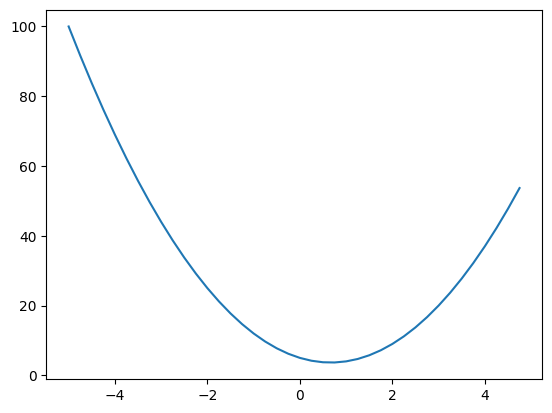

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.00000001
x = 2/3
(f(x + h) - f(x)) / h

0.0

In [7]:
a = 2.0
b = -3.0
c = 10
d = a*b + c
print(d)

4.0


In [8]:
h = 0.0001

a = 2.0
b = -3.0
c = 10
d1 = a*b + c
b += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)




d1 4.0
d2 4.0002
slope 2.0000000000042206


In [43]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | dt %.4f | gd %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [100]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), _op='+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), _op='-')

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), _op='*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return Value(self.data / other.data, (self, other), _op='/')

    def tanh(self):
        out = Value(math.tanh(self.data), (self,), _op='tanh')
        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for node in reversed(topo):
            node._backward()

In [69]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'

In [70]:
L.grad = 1
L._backward()
d._backward()
e._backward()
# d.grad = -2.0
# f.grad = 4
# c.grad = d.grad * 1
# e.grad = d.grad * 1
# a.grad = e.grad * -3.0
# b.grad = e.grad * 2.0
# L.data, L.grad, L._prev, L._op, L.label
#L.backprop()

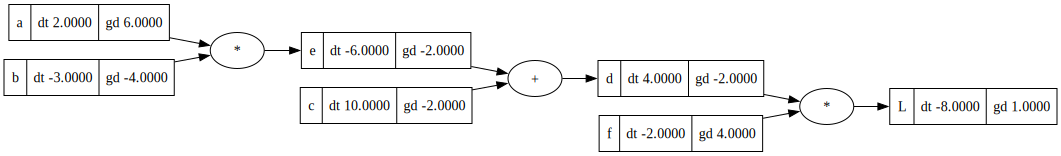

In [71]:
draw_dot(L)

In [13]:
'''
dd / dc
d = c + e -> local derivative of a sum -> 1
local derivative of a mul -> the other param

dl/dc = dl/dd (-2) * dd/dc (1) -> 4

de/da = ? e = a * b -> b -3 -> dl/da = dl/de * de/da = -2.0 * -3.0
de/db -> -2.0 * 2 -> -4.0
'''  

'\ndd / dc\nd = c + e -> local derivative of a sum -> 1\nlocal derivative of a mul -> the other param\n\ndl/dc = dl/dd (-2) * dd/dc (1) -> 4\n\nde/da = ? e = a * b -> b -3 -> dl/da = dl/de * de/da = -2.0 * -3.0\nde/db -> -2.0 * 2 -> -4.0\n'

In [14]:
u = 0.01
a.data += u * a.grad
b.data += u * b.grad
c.data += u * c.grad
f.data += u * f.grad
e = a * b
d = e + c
L = d * f
L


Value(data=-7.286496)

In [15]:
def lol():
    h = Value(-0.001)
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b') + h
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L

    print((L2 - L1) / h)

lol()
    

Value(data=-3.9999999999995595)


In [16]:
# neurons , multilateral perceptrons

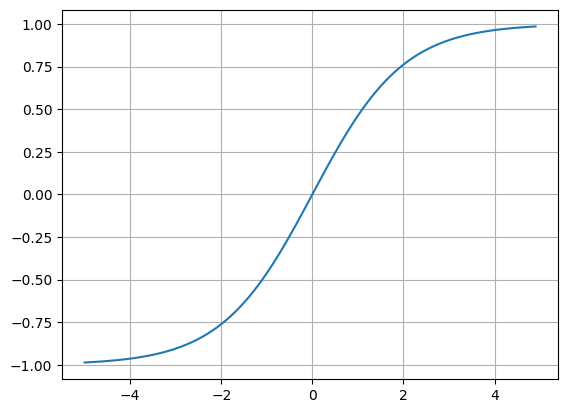

In [17]:
xs = np.arange(-5, 5, 0.1)
ys = np.tanh(xs / 2)
plt.plot(xs, ys)
plt.grid();

In [103]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.88137358701195432, label='b')

# neuron internal
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'


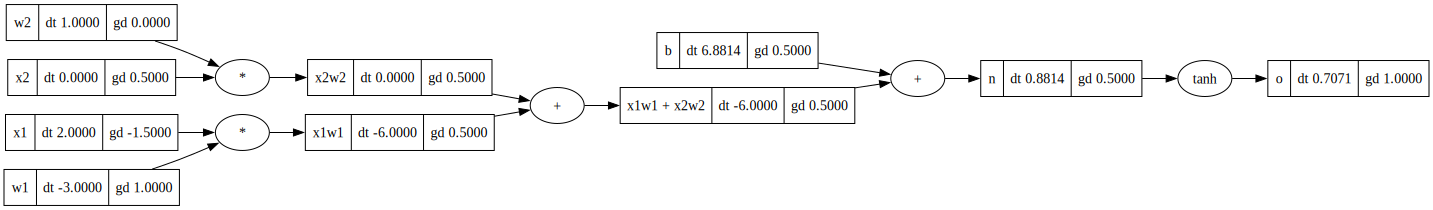

In [104]:
# ordering topological sort (order node with grad depency)
o.backward()
draw_dot(o)

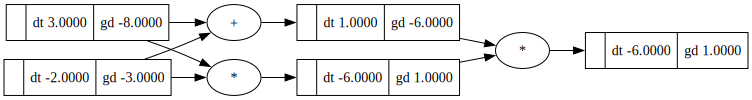

In [106]:
a = Value(-2.0)
b = Value(3.0)
d = a * b
e = a + b
f = d * e
f.backward()
draw_dot(f)